### Prematurity classification on the dHCP database.

In [1]:
import os 
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [2]:
region = "STs_right"

labels_path = "/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/participants.csv"
base_path = "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation"
    

region_path = os.path.join(base_path, region)
    
# Trouver le nom du dossier unique automatiquement
subdirs = [d for d in os.listdir(region_path) if os.path.isdir(os.path.join(region_path, d))]
if len(subdirs) != 1:
    raise RuntimeError(f"Il y a {len(subdirs)} sous-dossiers dans {region_path}, impossible de choisir automatiquement car il y a plusieurs modèles enregistrés par région.")
model_folder = subdirs[0]

# Construire les chemins complets
embedding_path = os.path.join(region_path, model_folder, "dHCP_random_embeddings", "full_embeddings.csv")

In [3]:

# Load embeddings and labels
labels_df = pd.read_csv(labels_path)
embeddings = pd.read_csv(embedding_path, index_col=0)
embeddings= embeddings.loc[embeddings.index.isin(labels_df['Subject'])]

# Visu labels
labels=labels_df["birth_age"]

print("Shape embeddings", embeddings.shape)
print("Shape labels", labels.shape)

# Scaling
scaler = StandardScaler().fit(embeddings)
Xs = scaler.transform(embeddings)

results = {}
for T in [28, 32, 37]:
    y = (labels < T).astype(int).values
    
    # Train linear SVC
    clf = SVC(kernel='linear', C=0.01, class_weight='balanced')
    clf.fit(Xs, y)
    scores = clf.decision_function(Xs)
    print("scores",min(scores),max(scores))

    # AUC
    auc = roc_auc_score(y, scores)

    # Permutation 
    auc_null = []
    for _ in range(200):
        y_perm = np.random.permutation(y)
        clf.fit(Xs, y_perm)
        auc_null.append(roc_auc_score(y_perm, clf.decision_function(Xs)))
    p_value = np.mean(np.array(auc_null) >= auc)
    ci95 = np.percentile(auc_null, 95)

    results[T] = {'AUC': auc, 'p_value': p_value, 'null95': ci95}

Shape embeddings (374, 32)
Shape labels (374,)
scores -3.674665501263269 2.5456998231489703
scores -2.694623160681393 2.2181606521608157
scores -2.3421247987455094 2.5789575309072235


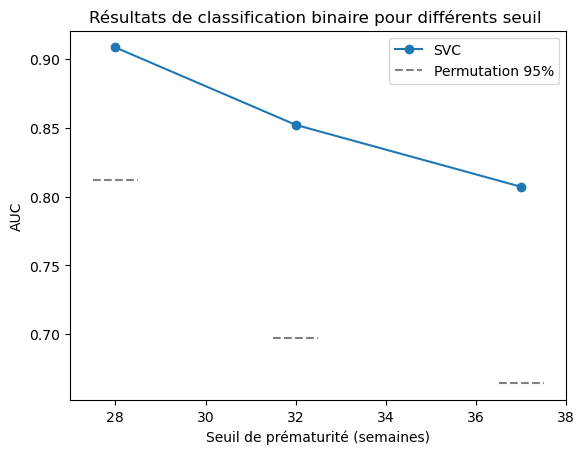

In [4]:
# Plots

seuils = list(results.keys())
aucs   = [results[T]['AUC'] for T in seuils]
ci95s  = [results[T]['null95'] for T in seuils]

plt.plot(seuils, aucs, marker='o', label='SVC')
plt.hlines(ci95s, [s-0.5 for s in seuils], [s+0.5 for s in seuils],
           linestyles='dashed', colors='gray', label='Permutation 95%')
plt.xlabel('Seuil de prématurité (semaines)')
plt.ylabel('AUC')
plt.legend()
plt.title(f"Résultats de classification binaire pour différents seuil ")
plt.show()


In [5]:
def train_SVC(region):
    
    region_path = os.path.join(base_path, region)
    
    # Trouver le nom du dossier unique automatiquement
    subdirs = [d for d in os.listdir(region_path) if os.path.isdir(os.path.join(region_path, d))]
    if len(subdirs) != 1:
        raise RuntimeError(f"Il y a {len(subdirs)} sous-dossiers dans {region_path}, impossible de choisir automatiquement car il y a plusieurs modèles enregistrés par région.")
    model_folder = subdirs[0]

    # Construire les chemins complets
    embedding_path = os.path.join(region_path, model_folder, "dHCP_random_embeddings", "full_embeddings.csv")
    embeddings = pd.read_csv(embedding_path, index_col=0)
    embeddings= embeddings.loc[embeddings.index.isin(labels_df['Subject'])]


    # Scaling
    scaler = StandardScaler().fit(embeddings)
    Xs = scaler.transform(embeddings)


    scores= {}
    for T in [28, 32, 37]:
        y = (labels < T).astype(int).values

        # Train linear SVC
        clf = SVC(kernel='linear', C=0.01, class_weight='balanced')
        clf.fit(Xs, y)
        pred = clf.decision_function(Xs)

        # AUC
        auc = roc_auc_score(y, pred)

        # Permutation 
        auc_null = []
        for _ in range(200):
            y_perm = np.random.permutation(y)
            clf.fit(Xs, y_perm)
            auc_null.append(roc_auc_score(y_perm, clf.decision_function(Xs)))
        p_value = np.mean(np.array(auc_null) >= auc)
        ci95 = np.percentile(auc_null, 95)

        scores[T] = {'AUC': auc, 'p_value': p_value, 'null95': ci95}

    return scores 

In [6]:
def get_all_results(regions):

    all_results = {}

    for region in regions :
        print(f"Traitement de la région {region}")
        region_scores= train_SVC(region)
        all_results[region] = region_scores

    return all_results

In [8]:
def get_region_list(base_path):
    return sorted([
        d for d in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, d))
           and not d.startswith('all_models')
           and not d.startswith('hcp')
           and not d.startswith('ukb')
           and not d.endswith('.csv')
           and not d.endswith('.sh')
           and not d.endswith('embeddings')
    ])

In [9]:
#Construire la liste des régions et calculer les stats
region_list = get_region_list(base_path)
stats_all   = get_all_results(region_list)

# Aplatir les résultats dans un DataFrame
records = []
for region, scores in stats_all.items():
    for threshold, metrics in scores.items():
        records.append({
            "region":     region,
            "threshold":  threshold,
            "AUC":        metrics["AUC"],
            "p_value":    metrics["p_value"],
            "null95":     metrics["null95"],
        })
df_results = pd.DataFrame(records)

# Export CSV
output_csv = "prematurity_classification_stats_1205.csv"
df_results.to_csv(output_csv, index=False)
print(f"Résultats exportés dans : {output_csv}")



Traitement de la région CINGULATE_left
Traitement de la région CINGULATE_right
Traitement de la région FCLp-subsc-FCLa-INSULA_left
Traitement de la région FCLp-subsc-FCLa-INSULA_right
Traitement de la région FCMpost-SpC_left
Traitement de la région FCMpost-SpC_right
Traitement de la région FColl-SRh_left
Traitement de la région FColl-SRh_right
Traitement de la région FIP_left
Traitement de la région FIP_right
Traitement de la région FPO-SCu-ScCal_left
Traitement de la région FPO-SCu-ScCal_right
Traitement de la région LARGE_CINGULATE_left
Traitement de la région LARGE_CINGULATE_right
Traitement de la région Lobule_parietal_sup_left
Traitement de la région Lobule_parietal_sup_right
Traitement de la région OCCIPITAL_left
Traitement de la région OCCIPITAL_right
Traitement de la région SC-SPeC_left
Traitement de la région SC-SPeC_right
Traitement de la région SC-SPoC_left
Traitement de la région SC-SPoC_right
Traitement de la région SC-sylv_left
Traitement de la région SC-sylv_right
Traite

In [ ]:
# pivoter le CSV des stats pour obtenir une colonne AUC par seuil
import pandas as pd

df = pd.read_csv('prematurity_classification_stats.csv')

# Pivot pour avoir une colonne AUC par seuil
df_pivot = df.pivot(index='region', columns='threshold', values='AUC')

# Renommer les colonnes pour clarifier
df_pivot = df_pivot.rename(columns={
    28: 'AUC_28',
    32: 'AUC_32',
    37: 'AUC_37'
}).reset_index()

# Sauvegarder le nouveau CSV
output_csv = 'prematurity_AUC_by_region.csv'
df_pivot.to_csv(output_csv, index=False)
print(f"Fichier généré : {output_csv}")




In [61]:
def get_pred_confidence(region, threshold, C=0.01):
    """
    Pour une région et un seuil donné, entraîne un SVC linéaire,
    récupère la decision_function pour chaque sujet,
    et renvoie un DataFrame trié par confiance.
    
    Columns:
      - ID         : identifiant du sujet (index des embeddings)
      - confidence : valeur de decision_function
      - label      : étiquette 0/1 selon (GestAge < threshold)
    """

    region_path = os.path.join(base_path, region)
    subdirs = [d for d in os.listdir(region_path)
               if os.path.isdir(os.path.join(region_path, d))]
    if len(subdirs) != 1:
        raise RuntimeError(f"{len(subdirs)} modèles dans {region_path}")
    model_folder = subdirs[0]
    emb_path = os.path.join(region_path, model_folder,
                            "dHCP_random_embeddings", "full_embeddings.csv")
    embeddings = pd.read_csv(emb_path, index_col=0)
    print(labels_df.head())
    embeddings = embeddings.loc[embeddings.index.isin(labels_df["Subject"])]
    print(embeddings.shape)

    # Scaling
    scaler = StandardScaler().fit(embeddings)
    Xs = scaler.transform(embeddings)

    print(labels)

    # Construction de y
    y = (labels < threshold).astype(int).values

    # Entraînement SVC et extraction des confidences
    clf = SVC(kernel='linear', C=C, class_weight='balanced')
    clf.fit(Xs, y)
    confidences = clf.decision_function(Xs)

    # 5. DataFrame résultat
    df_conf = pd.DataFrame({
        'ID'        : embeddings.index,
        'confidence': confidences,
        'label'     : y
    })
    #  Tri décroissant
    df_conf = df_conf.sort_values('confidence', ascending=False).reset_index(drop=True)
    return df_conf
    


In [ ]:
df_conf = get_pred_confidence("STs_right", threshold=32)
# Les 10 sujets pour lesquels le SVC est le plus confiant :
#print(df_conf.head(10))

# Export du classement 
df_conf[['ID','confidence']].to_csv("csv/confidence_STs_right_32w.csv", index=False)




           Subject  session_id  birth_age  Preterm_28  Preterm_30  Preterm_32  \
0  sub-CC00065XX08       18600  40.428571           0           0           0   
1  sub-CC00067XX10       20200  40.000000           0           0           0   
2  sub-CC00068XX11       20701  40.428571           0           0           0   
3  sub-CC00071XX06       27000  39.857143           0           0           0   
4  sub-CC00073XX08       27800  40.714286           0           0           0   

   Preterm_34  Preterm_37  
0           0           0  
1           0           0  
2           0           0  
3           0           0  
4           0           0  
(374, 32)
0      40.428571
1      40.000000
2      40.428571
3      39.857143
4      40.714286
         ...    
369    42.000000
370    41.571429
371    39.857143
372    41.857143
373    40.428571
Name: birth_age, Length: 374, dtype: float64


In [74]:
print(labels_df.columns)
labels_df_new = labels_df.drop(columns=["session_id", "Preterm_28", "Preterm_30", "Preterm_32", "Preterm_34", "Preterm_37"],inplace=True)

labels_df_new.to_csv("labels_df_filtered.csv", index=False)


Index(['Subject', 'birth_age'], dtype='object')


KeyError: "['session_id', 'Preterm_28', 'Preterm_30', 'Preterm_32', 'Preterm_34', 'Preterm_37'] not found in axis"

In [ ]:
labels_df.to_csv("csv/birth_age_dHCP.csv", index=False)


In [78]:
print(get_region_list(base_path))

['CINGULATE_left', 'CINGULATE_right', 'FCLp-subsc-FCLa-INSULA_left', 'FCLp-subsc-FCLa-INSULA_right', 'FCMpost-SpC_left', 'FCMpost-SpC_right', 'FColl-SRh_left', 'FColl-SRh_right', 'FIP_left', 'FIP_right', 'FPO-SCu-ScCal_left', 'FPO-SCu-ScCal_right', 'LARGE_CINGULATE_left', 'LARGE_CINGULATE_right', 'Lobule_parietal_sup_left', 'Lobule_parietal_sup_right', 'OCCIPITAL_left', 'OCCIPITAL_right', 'SC-SPeC_left', 'SC-SPeC_right', 'SC-SPoC_left', 'SC-SPoC_right', 'SC-sylv_left', 'SC-sylv_right', 'SFinf-BROCA-SPeCinf_left', 'SFinf-BROCA-SPeCinf_right', 'SFint-FCMant_left', 'SFint-FCMant_right', 'SFint-SR_left', 'SFint-SR_right', 'SFinter-SFsup_left', 'SFinter-SFsup_right', 'SFmarginal-SFinfant_left', 'SFmarginal-SFinfant_right', 'SFmedian-SFpoltr-SFsup_left', 'SFmedian-SFpoltr-SFsup_right', 'SOr-SOlf_left', 'SOr-SOlf_right', 'SOr_left', 'SOr_right', 'SPeC_left', 'SPeC_right', 'SPoC_left', 'SPoC_right', 'STi-SOTlat_left', 'STi-SOTlat_right', 'STi-STs-STpol_left', 'STi-STs-STpol_right', 'STs_left',

In [ ]:
python local_averages.py -r "S.Or." -i "L" -d "dHCP" -p "/neurospin/dico/rmenasria/Runs/01_essai/Program/2023_jlaval_STSbabies/contrasti
ve/notebooks/racim/csv/birth_age_dHCP.csv" -s "Subject" -e "birth_age"